## Step1: Create a sample dataset for model development and local code debug

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
names_df = pd.read_csv('../data/us-names.csv', nrows=1000)
train_df, test_df = train_test_split(names_df, test_size=0.2, random_state=123)
print(train_df.shape, test_df.shape)

(800, 2) (200, 2)


In [3]:
train_df.head()

,name,gender
512,Katheryn,F
685,Cathleen,F
997,Carmelita,F
927,Lavona,F
376,Beverly,F


In [4]:
train_df.isna().sum()

name      0
gender    0
dtype: int64

In [5]:
test_df.isna().sum()

name      0
gender    0
dtype: int64

In [6]:
train_df.to_csv("../data/sample_train_df.csv", index=False)
test_df.to_csv("../data/sample_test_df.csv", index=False)

## Step2: Build a distributable tensorflow data preprocessing pipeline and model

In [8]:
import string
import tensorflow as tf
import numpy as np
print(tf.__version__)

LETTERS = " " + string.ascii_lowercase
EMBEDDING = 256
filter_size=100

2.3.2


In [9]:
def dynamic_padding(inp, min_size):
    # https://stackoverflow.com/questions/42334646/tensorflow-pad-unknown-size-tensor-to-a-specific-size
    pad_size = min_size - tf.shape(inp)[0]
    paddings = [[0, pad_size]] # Pad behind the name with spaces to align with padding from to_tensor default_value
    return tf.pad(inp, paddings, mode="CONSTANT", constant_values=" ") # 32 is the UTF-8 value for space

def x_preprocess(x):
    x_processed = tf.strings.lower(x)
    try:
        x_processed = tf.strings.unicode_split(x_processed, input_encoding="UTF-8").to_tensor(default_value=" ") #TODO: in TF2.0 can add an argument shape=[batch_size,100] to do padding/pruning here
    except:
        x_processed = tf.strings.unicode_split(x_processed, input_encoding="UTF-8")
    
    # Pad only if necessary
    x_processed = tf.cond(tf.less(tf.shape(x_processed)[1], filter_size), 
                          true_fn=lambda: tf.map_fn(lambda inp_name: dynamic_padding(inp_name, filter_size), x_processed), 
                          false_fn=lambda: tf.map_fn(lambda inp_name: tf.slice(inp_name, tf.constant([0]), tf.constant([100])), x_processed))
    
    x_processed = tf.strings.unicode_decode(x_processed, 'UTF-8')-96 # make a=1
    x_processed = tf.map_fn(lambda item: (tf.map_fn(lambda subitem: 0 if (subitem[0]<0 or subitem[0]>26) else subitem[0], item)), 
                            x_processed.to_tensor())
    
    return x_processed

def preprocess(x, y):
    """tf.data compatible preprocessing"""
    x_processed = x_preprocess(x)
    y_processed = tf.cast(tf.equal(y, "M"), dtype=tf.int32)#tf.cond(tf.equal(y, "F"), lambda: 0.0, lambda: 1.0)

    return x_processed, y_processed

In [10]:
def _parse_function(proto):
    # tfrecord format definiton
    keys_to_features = {"name": tf.io.FixedLenFeature([], tf.string),
                        "gender": tf.io.FixedLenFeature([], tf.string)}
    
    # Load batch examples
    parsed_features = tf.io.parse_example(proto, keys_to_features)
    
    x = parsed_features["name"]
    y =  parsed_features["gender"]
       
    return x, y

In [11]:
# Read data
def csv_reader_dataset(filepaths, repeat=1, n_readers=8, n_read_threads=8, shuffle_buffer_size=1000, n_parse_threads=8, batch_size=32):
    """Read sharded csv files, preprocess, shuffle and create batches using tf.data API"""
    dataset = tf.data.Dataset.list_files(filepaths)

    # creat a tfdataset from the csv file
    defs = [tf.constant(["NaN"], dtype=tf.string)]*2
    dataset = dataset.interleave(lambda filepath: tf.data.experimental.CsvDataset(filepath, defs, select_cols=[0,1], header=True), 
                                 cycle_length=n_readers, num_parallel_calls=n_read_threads)

    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size).repeat()
    return dataset.batch(batch_size).prefetch(1)

In [12]:
def tfrecord_reader_dataset(filepaths, repeat=1, n_readers=8, n_read_threads=8, shuffle_buffer_size=1000, n_parse_threads=8, batch_size=32):
    dataset = (tf.data.Dataset
               .list_files(filepaths)
               .interleave(tf.data.TFRecordDataset, 
                           cycle_length=tf.data.experimental.AUTOTUNE, num_parallel_calls=tf.data.experimental.AUTOTUNE)
               .shuffle(shuffle_buffer_size).repeat()
               .batch(batch_size, drop_remainder=True)
               .map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
               .map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
               .prefetch(tf.data.experimental.AUTOTUNE)
              )
    
    return dataset

In [13]:
# Model
def build_dnn_model():
    """Construct model using tf.keras API"""
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(len(LETTERS), EMBEDDING, input_length=100, name="embedding"))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128), name="bi-lstm"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="output"))  
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    return model

In [14]:
# Mirrored Strategy to distribute training
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_dnn_model()

# Check the model architecture
print(model.summary())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 256)          6912      
_________________________________________________________________
bi-lstm (Bidirectional)      (None, 256)               394240    
_________________________________________________________________
output (Dense)               (None, 1)                 257       
Total params: 401,409
Trainable params: 401,409
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
#tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Step3: Train and Evaluate

In [16]:
TRAIN_BATCH_SIZE = 512
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 1000 # enough to get a reasonable sample, but not so much that it slows down
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

#train_set = csv_reader_dataset("../data/train*.csv", batch_size=TRAIN_BATCH_SIZE)
#eval_set = csv_reader_dataset("../data/eval*.csv", batch_size=NUM_EVAL_EXAMPLES).take(NUM_EVAL_EXAMPLES)

train_set = tfrecord_reader_dataset("../data/tfrecords/us_names_train*.tfrecord", batch_size=TRAIN_BATCH_SIZE)
test_set = tfrecord_reader_dataset("../data/tfrecords/us_names_val*.tfrecord", batch_size=NUM_EVAL_EXAMPLES).take(NUM_EVAL_EXAMPLES)

In [17]:
def show_batch(dataset):
    for batch in dataset.take(3):
        print(batch)
        
show_batch(train_set)

(<tf.Tensor: shape=(512, 100), dtype=int32, numpy=
array([[26,  5, 12, ...,  0,  0,  0],
       [ 6, 18,  1, ...,  0,  0,  0],
       [19,  9, 18, ...,  0,  0,  0],
       ...,
       [ 5, 12,  9, ...,  0,  0,  0],
       [ 3, 18,  9, ...,  0,  0,  0],
       [ 2,  1, 19, ...,  0,  0,  0]], dtype=int32)>, <tf.Tensor: shape=(512,), dtype=int32, numpy=
array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,

In [18]:
history = model.fit(train_set, validation_data=test_set, epochs=NUM_EVALS,
                    steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch)

Epoch 1/5
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
19/19 [==============================] - 99s 5s/step - loss: 0.6658 - accuracy: 0.6014 - val_loss: 0.6500 - val_accuracy: 0.5991
Epoch 2/5
19/19 [==============================] - 98s 5s/step - loss: 0.6110 - accuracy: 0.6569 - val_loss: 0.5890 - val_accuracy: 0.6826
Epoch 3/5
19/19 [==============================] - 98s 5s/step - loss: 0.5608 - accuracy: 0.7147 - val_loss: 0.5677 - val_accuracy: 0.7057
Epoch 4/5
19/19 [==============================] - 99s 5s/step - loss: 0.5656 - accuracy: 0.7099 - val_loss: 0.5662 - val_accuracy: 0.7027
Epoch 5/5
19/19 [==============================] - 98s 5s/step - loss: 0.5558 - accuracy: 0.7215 - val_loss: 0.5570 - val_accuracy: 0.7153


In [25]:
# Save trained model
tf.saved_model.save(model, export_dir='../models/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/assets


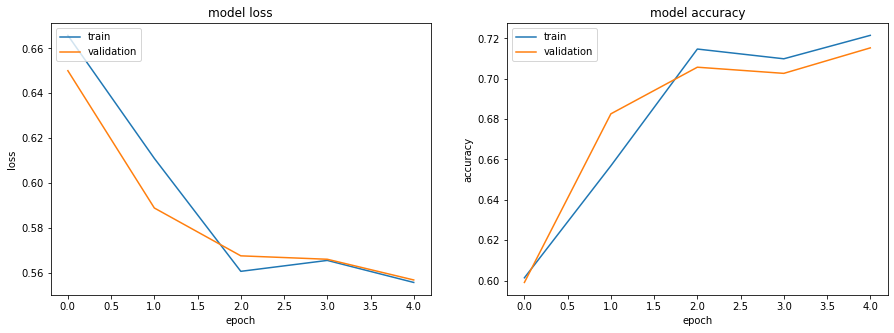

In [20]:
# plot the loss curve
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(15, 5))

for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

In [21]:
sample_data = tf.reshape(x_preprocess(["stephen"]), [1, 100])
model.predict(sample_data)

array([[0.5780653]], dtype=float32)

In [23]:
sample_data = tf.reshape(x_preprocess(["stephanie"]), [1, 100])
model.predict(sample_data)

array([[0.05642173]], dtype=float32)

In [26]:
model.predict(test_set)

array([[0.6063766 ],
       [0.5305096 ],
       [0.15249217],
       ...,
       [0.7216294 ],
       [0.67348754],
       [0.6630709 ]], dtype=float32)